In [7]:
import pandas as pd

from datasets.fishtox import FishTox
from datasets.utils import prepare_molecular_dataset
dataset = FishTox('/data')

In [8]:
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')


In [ ]:
from encoder import MoleBERTEncoder

encoder = MoleBERTEncoder()
molecular_representation = encoder(smiles)

In [4]:
from encoder import *

encoders = []
for pool in ['mean']:#, 'sum', 'max']:
    encoders += [
        ChemBERTaEncoder(pool=pool),
        MolCLREncoder(architecture='GIN', pool=pool),
        # MolCLREncoder(architecture='GCN', pool=pool),
        MoleBERTEncoder(pool=pool)
    ]
# 
encoders

Instantiating the model.


/home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/transformers/models/auto/modeling_auto.py:1581: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Some weights of the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassifica

In [11]:
from torch_mist import estimate_mi
from tqdm.auto import tqdm
from torch.utils.data import Subset

train_logs = []
mis = []
estimators = []


estimator_parameters = {
    'estimator_name': 'smile',
    'hidden_dims': [256],
    'batch_size': 64,
    'neg_samples': 8,
    'max_iterations': 10000,
    'warmup_percentage': 0.01,
    'return_estimator': True,
    'patience': 10,
    'verbose': False,
}

seeds = [7, 42, 404]

for encoder in tqdm(encoders):
    name = encoder.name
    
    encoded_dataset = prepare_molecular_dataset(dataset, encoder, representation_path='/data/representations', read_only=True)
    valid_representations = [(z!=z).sum() == 0 for z,_ in encoded_dataset]
    
    for seed in seeds:
        np.random.seed(seed)
        order = np.random.permutation(len(dataset))
        
        split_idx = int(len(dataset)*0.9)
        train_ids = order[:split_idx]
        test_ids = order[split_idx:]
        
        train_set = Subset(encoded_dataset, [idx for idx in train_ids if valid_representations[idx]])
        test_set = Subset(encoded_dataset, [idx for idx in test_ids if valid_representations[idx]])
        
        mi_value, estimator, train_log = estimate_mi(
            data=train_set,
            test_data=test_set,
            **estimator_parameters
        )
        break
        
        encoder_name ='_'.join(name.split('_')[:-1])
        pool = name.split('_')[-1]
        train_log['encoder'] = encoder_name
        train_log['pool'] = pool
        train_log['seed'] = seed
        train_logs.append(train_log)
        
        mis.append({
            'mutual_information': mi_value,
            'encoder': encoder_name,
            'pool': pool,
            'seed': seed
        })
        
        estimators.append({
            'estimator': estimator,
            'encoder': encoder_name,
            'pool': pool,
            'seed': seed
        })

    break
mis = pd.DataFrame(mis)
estimators = pd.DataFrame(estimators)
train_logs = pd.concat(train_logs)

  0%|          | 0/3 [00:00<?, ?it/s]

Opening /data/representations/ChemBERTa_zinc250k_v2_40k_mean/values.h5py
Instantiating the smile estimator
Instantiating the estimator with {'estimator_name': 'smile', 'hidden_dims': [256], 'neg_samples': 8, 'x_dim': 768, 'y_dim': 1}
SMILE(
  (ratio_estimator): JointCritic(
    (joint_net): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=769, out_features=256, bias=True)
        (1): Linear(in_features=256, out_features=1, bias=True)
      )
      (f): ReLU(inplace=True)
    )
  )
  (baseline): BatchLogMeanExp()
  (neg_samples): 8
)


  0%|          | 0/3 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [12]:
import pickle

with open('cached_results/fishtox_estimators.pkl', 'rb') as file:
    estimators = pickle.load(file)

ChemBERTa_zinc250k_v2_40k_mean
ChemBERTa_zinc250k_v2_40k mean
MolCLR_GIN_mean
MolCLR_GIN mean
MoleBERT_mean
MoleBERT mean


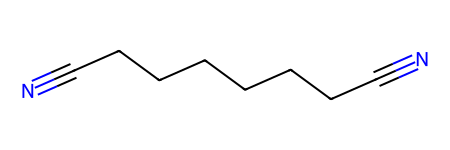

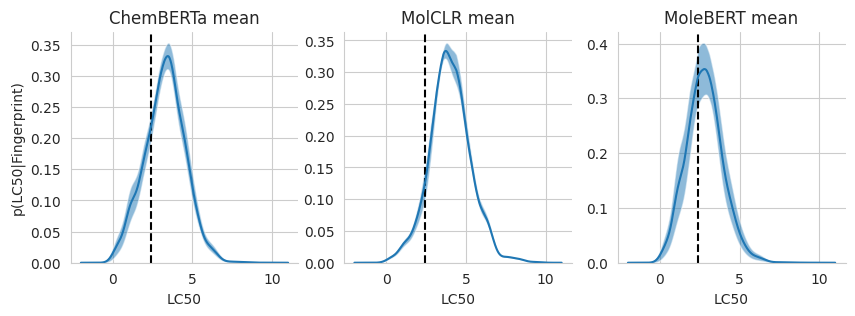

In [15]:
from rdkit import Chem
from sklearn.neighbors import KernelDensity
import torch
import matplotlib.pyplot as plt

kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(dataset.y.data.numpy())
res = 1000
t = torch.linspace(-2,11, res).view(-1,1)
p_tox = np.exp(kde.score_samples(t))

f, ax = plt.subplots(1, len(encoders[:3]), figsize=(10,3))

# ax[0].plot(t[:,0], p_tox)
# ax[0].set_ylim(0)
# ax[0].set_xlabel('LC50')
# ax[0].set_ylabel('p(LC50)')


test_idx = test_ids[3]
smile = dataset.smiles[test_idx]

ax[0].set_ylabel('p(LC50|Fingerprint)')
for i, encoder in enumerate(encoders[:3]):
    print(encoder.name)
    z = encoder(smile)
    name = encoder.name
    encoder_name = '_'.join(name.split('_')[:-1])
    pool = name.split('_')[-1]
    ax[i].axvline(x=dataset.y[test_idx], ls = '--', label='Ground Truth', color = 'k')
    
    print(encoder_name, pool)
    
    p = []
    
    trained_estimators = estimators[estimators['encoder'] == encoder_name]
    trained_estimators = trained_estimators[trained_estimators['pool'] == pool]
    
    for _, estimator in trained_estimators.iterrows():
        estimator = estimator['estimator']
        
        u_log_r = estimator.unnormalized_log_ratio(
            x=torch.FloatTensor(z).unsqueeze(0), 
            y=t
        ).data.numpy()
        
        u_tox_given_f =  np.exp(kde.score_samples(t)+u_log_r)
        u_tox_given_f = u_tox_given_f/u_tox_given_f.sum()/(t[1]-t[0])
        p.append(u_tox_given_f.reshape(1,-1))
        
    p = np.concatenate(p, 0)
        
    ax[i].plot(t[:,0], p.mean(0), label=name)
    ax[i].fill_between(t[:,0], p.mean(0)+p.std(0), p.mean(0)-p.std(0), alpha=0.5)
    ax[i].set_ylim(0)
    ax[i].set_xlabel('LC50')

    ax[i].set_title(encoder_name.split('_')[0]+' '+pool)
        
# ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
Chem.MolFromSmiles(smile,)

In [ ]:
f, ax = plt.subplots(1,1)
sns.barplot(mis, x='encoder', y='mutual_information', ax = ax, hue='pool')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [7]:
import pickle

with open('cached_results/fishtox_estimators.pkl', 'wb') as file:
    pickle.dump(estimators, file)